In [11]:
# 0. 라이브러리 불러오기
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from sklearn.metrics import average_precision_score
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# 1. CIFAR-100 데이터셋 로드 및 전처리
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5071, 0.4867, 0.4408],
        std =[0.2675, 0.2565, 0.2761]
    )
])

# Train / Test Dataset & DataLoader
train_dataset = torchvision.datasets.CIFAR100(
    root="CIFAR100_Dataset",
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.CIFAR100(
    root="CIFAR100_Dataset",
    train=False,
    download=True,
    transform=transform
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=False, num_workers=2
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=128, shuffle=False, num_workers=2
)

100%|██████████| 169M/169M [00:05<00:00, 29.5MB/s]


In [12]:
# 2. ResNet-18 모델로 특징 추출기 정의
class ResNet18FeatureExtractor(nn.Module):
    def __init__(self):
        super(ResNet18FeatureExtractor, self).__init__()
        resnet = torchvision.models.resnet18(pretrained=True)
        # 마지막 FC layer 제거 → feature 벡터만 사용
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])

    def forward(self, x):
        x = self.feature_extractor(x)           # [B, 512, 1, 1]
        x = x.view(x.size(0), -1)              # [B, 512]
        return x

# 디바이스 설정 및 모델 준비
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18FeatureExtractor().to(device)
model.eval()



/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet18FeatureExtractor(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [13]:
# 3. Train/Test 데이터에서 특징 벡터 뽑기
def extract_features(loader):
    features = []
    labels = []
    with torch.no_grad():
        for inputs, targets in tqdm(loader, desc="Extracting Features"):
            inputs = inputs.to(device)
            outputs = model(inputs)  # [B, 512]
            features.append(outputs.cpu().numpy())
            labels.append(targets.cpu().numpy())
    features = np.concatenate(features, axis=0)   # (N, 512)
    labels = np.concatenate(labels, axis=0)       # (N,)
    return features, labels

train_features, train_labels = extract_features(train_loader)
test_features, test_labels   = extract_features(test_loader)

Extracting Features: 100%|██████████| 79/79 [00:27<00:00,  2.84it/s]


In [14]:
# 4. 유클리디안 거리 함수
def euclidean_distance(query_feature, database_features):
    """
    query_feature: (D,)
    database_features: (N, D)
    return: (N,) 각 샘플과의 거리
    """
    distances = np.linalg.norm(database_features - query_feature, axis=1)
    return distances

In [15]:
# 5. 검색 결과 (Top-K) 얻기
def get_top_k_results(query_feature, database_features, database_labels, k=5):
    distances = euclidean_distance(query_feature, database_features)
    indices = np.argsort(distances)[:k]              # 거리 작은 순으로 k개
    return indices, database_labels[indices]

In [16]:
# 6. mAP 계산 함수
def calculate_map(test_features, test_labels, database_features, database_labels, top_k=5):
    """
    test_features/labels 를 쿼리로 사용하고,
    database_features/labels 에서 비슷한 이미지를 검색했을 때의 mAP 계산
    """
    average_precisions = []

    for i in tqdm(range(len(test_features)), desc="Calculating mAP"):
        query_feature = test_features[i]
        query_label   = test_labels[i]

        # 데이터베이스에서 자기 자신은 제외
        valid_indices = np.setdiff1d(np.arange(len(database_features)), [i])
        valid_database_features = database_features[valid_indices]
        valid_database_labels   = database_labels[valid_indices]

        # 유사한 이미지 검색
        top_k_indices, top_k_labels = get_top_k_results(
            query_feature,
            valid_database_features,
            valid_database_labels,
            k=top_k
        )

        # 정답 여부(같은 클래스면 1, 아니면 0)
        relevance = (top_k_labels == query_label).astype(int)

        # relevance에 1이 하나도 없으면 AP 정의 불가 → 건너뜀
        if relevance.sum() > 0:
            # 점수는 랭크 기반 (1등이 가장 큰 점수)
            scores = np.arange(len(relevance), 0, -1)
            ap = average_precision_score(relevance, scores)
            average_precisions.append(ap)

    if len(average_precisions) == 0:
        return 0.0
    return float(np.mean(average_precisions))

# mAP 계산 및 출력
map_score = calculate_map(
    test_features, test_labels,
    test_features, test_labels,
    top_k=5
)
print(f"Mean Average Precision (mAP): {map_score:.4f}")
print(f"Mean Average Precision (mAP): {map_score * 100:.2f}%")



Calculating mAP: 100%|██████████| 10000/10000 [03:23<00:00, 49.09it/s]

Mean Average Precision (mAP): 0.6432
Mean Average Precision (mAP): 64.32%


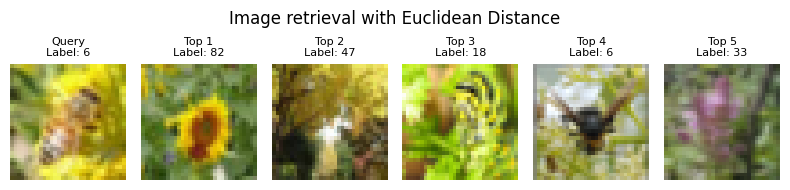

In [17]:
# 7. Normalize 풀어서 그림으로 보여주기 위한 함수들
def unnormalize(img, mean, std):
    """
    Normalize를 해제하여 원래 픽셀 값으로 복원.
    img: Tensor (C, H, W)
    """
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)   # 역으로 std 곱하고 mean 더함
    return img

# CIFAR-100에서 사용했던 mean, std
mean = [0.5071, 0.4867, 0.4408]
std  = [0.2675, 0.2565, 0.2761]

def visualize_query_and_results(query_index, test_features, test_labels, top_k=5):
    """
    query_index 번째 이미지를 쿼리로 사용해
    유클리디안 거리 기반 검색 결과를 시각화
    """
    query_feature = test_features[query_index]
    query_label   = test_labels[query_index]

    # Test set 내부에서 검색 수행 (자기 자신 제외)
    valid_indices = np.setdiff1d(np.arange(len(test_features)), [query_index])
    valid_test_features = test_features[valid_indices]
    valid_test_labels   = test_labels[valid_indices]

    top_k_indices, top_k_labels = get_top_k_results(
        query_feature,
        valid_test_features,
        valid_test_labels,
        k=top_k
    )

    # 그림 준비 (쿼리 + top_k 결과)
    fig, axes = plt.subplots(1, top_k + 1, figsize=(8, 2))
    fig.suptitle("Image retrieval with Euclidean Distance", fontsize=12)

    # 쿼리 이미지
    query_image, _ = test_dataset[query_index]
    query_image = unnormalize(query_image.clone(), mean, std)
    axes[0].imshow(query_image.permute(1, 2, 0).numpy())
    axes[0].axis("off")
    axes[0].set_title(f"Query\nLabel: {query_label}", fontsize=8)

    # 검색 결과 이미지들
    for i, idx in enumerate(top_k_indices):
        retrieved_image, _ = test_dataset[valid_indices[idx]]
        retrieved_image = unnormalize(retrieved_image.clone(), mean, std)
        axes[i + 1].imshow(retrieved_image.permute(1, 2, 0).numpy())
        axes[i + 1].axis("off")
        axes[i + 1].set_title(
            f"Top {i + 1}\nLabel: {top_k_labels[i]}", fontsize=8
        )

    plt.tight_layout()
    plt.show()

# 예시 실행 (원하면 index 값을 바꿔도 됨)
visualize_query_and_results(
    query_index=200,
    test_features=test_features,
    test_labels=test_labels,
    top_k=5
)